In [96]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from simdata import HT_sim, scaler,fdd, pdeinp,icinp,bcinp


In [97]:
L = 15e-3

time_end = 40.0
numpoints = 50
t_surr = 500.0
temp_init = 919.0

In [98]:
heat_data = HT_sim(L, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
print(alpha)
tempfield = heat_data.datagen()

# heat_data.plot_temp(25)

# Temperature dataset
temp_data = tempfield.flatten()

# temp_data = scaler(temp_data,400.0,919.0)


# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 
print(numpoints, num_steps)
print(numpoints*num_steps) 
inp_data = fdd(15e-3, 40, numpoints, num_steps,scl="false")



3.394878564540885e-05
50 31470
1573500


In [99]:
def pde(x, y):
    # pde for heat equation
    dy_t = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=1)
    return dy_t - alpha*dy_xx

In [100]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, time_end)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 500.0, lambda _, on_boundary: on_boundary)

ic = dde.IC(geomtime, lambda x: 919.0, lambda _, on_initial: on_initial)

In [101]:
data = dde.data.TimePDE(geomtime, \
                        pde,\
                        [bc, ic], \
                      num_domain=10000, \
                     num_boundary=10000, \
                        num_initial=10000, num_test=10000)

In [102]:
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)



In [103]:
model.compile("adam", lr=0.001)
model.train(iterations=50000)
model.compile("L-BFGS-B")

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000310 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.35e-02, 2.48e+05, 8.45e+05]    [1.77e-02, 2.48e+05, 8.45e+05]    []  
1000      [1.39e-04, 1.91e+05, 7.33e+05]    [8.96e-07, 1.91e+05, 7.33e+05]    []  
2000      [1.17e-05, 1.51e+05, 6.51e+05]    [7.95e-08, 1.51e+05, 6.51e+05]    []  
3000      [2.25e-06, 1.16e+05, 5.76e+05]    [1.58e-08, 1.16e+05, 5.76e+05]    []  
4000      [5.88e-07, 8.58e+04, 5.07e+05]    [4.27e-09, 8.58e+04, 5.07e+05]    []  
5000      [1.81e-07, 6.07e+04, 4.43e+05]    [1.34e-09, 6.07e+04, 4.43e+05]    []  
6000      [6.10e-08, 4.02e+04, 3.84e+05]    [4.67e-10, 4.02e+04, 3.84e+05]    []  
7000      [2.10e-08, 2.40e+04, 3.29e+05]    [1.66e-10, 2.40e+04, 3.29e+05]    []  
8000      [8.06e-09, 1.21e+04, 2.80e+05]    [6.35e-11, 1.21e+04, 2.80e+05]    []  
9000      [2.66e-09, 4.37e+03, 2.35e+05]    [2.02e-11, 4.37e+03, 2.35e+05]    []  
10000     [5.82

(1573500, 1)
(31470, 50)


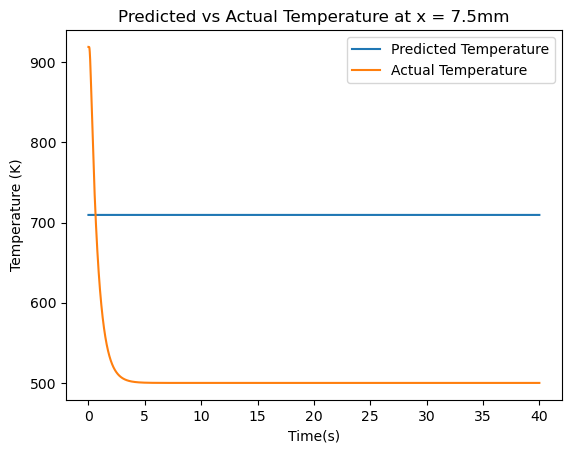

In [104]:
y_pred = model.predict(inp_data)
print(y_pred.shape)
temp_nn = y_pred.reshape(num_steps, numpoints)
print(temp_nn.shape)
time_ss= np.linspace(0, 40.0, num_steps )

plt.figure
plt.plot(time_ss, temp_nn[:,25 ], label='Predicted Temperature')
plt.plot(time_ss, tempfield[:,25], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()

